In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
%matplotlib inline

In [24]:
plt.rcParams["figure.figsize"] = (11,6)
plt.rcParams["font.size"] = 12

## Problem 1

We have some function $f(x)$ sampled at four points: $f(x\pm\delta)$ and $f(x\pm2\delta)$. We can use these points to estimate the derivative of $f$ at $x$ by examining the Taylor expansion of $f$ near $x$:
  
$$
f(x+\epsilon) = f(x) + \epsilon f'(x) + \frac{1}{2}\epsilon^2 f''(x) + \cdots,
$$
  
where $\epsilon \ll 1$. From the Taylor expansion, it follows that
  
$$
f'(x) \approx \frac{f(x+\delta) - f(x-\delta)}{2\delta},
$$
  
and
  
$$
f'(x) \approx \frac{f(x+2\delta) - f(x-2\delta)}{4\delta}.
$$
  
We can average these estimates to get
  
$$
f'(x) \approx \frac{2f(x+\delta) - 2f(x-\delta) + f(x+2\delta) - f(x-2\delta)}{8\delta}.
$$
  
An implementation of this approximation is provided in the following cells. Note that we are unable to estimate the derivative at the first and last two sample points, and that this implementation will likely not give a great estimate of the derivative for irregularly sampled data.

In [3]:
def estimate_derivative(x, y):
    """
    Estimate the derivative of y(x).
    
    This function estimates the derivative of y(x) at each
    x in x[2:-2] using four sample points, y(x+dx), y(x-dx),
    y(x+2dx), and y(x-2dx). The derivative y'(x) is approximately
    y'(x) ~ (2y(x+dx) - 2y(x-dx) + y(x+2dx) - y(x-2dx))/8dx.
    
    Parameters
    ----------
    x: array-like of float
        Values the function is evaluated at.
        
    y: array-like of float
        Function evaluated at each x.
        
    Returns
    -------
    dydx_approx: ndarray
        Approximation of the derivative of y at x[2:-2].
    """
    x = np.array(x)
    y = np.array(y)
    dx = np.mean(np.diff(x))
    return (2 * y[3:-1] - 2 * y[1:-3] + y[4:] - y[:-4]) / (8 * dx)

In [4]:
x = np.linspace(-1, 1, 1000)
y = np.exp(0.01 * x)
dydx = estimate_derivative(x,y)
true_derivative = 0.01 * y
error = np.std(true_derivative[2:-2] - dydx)

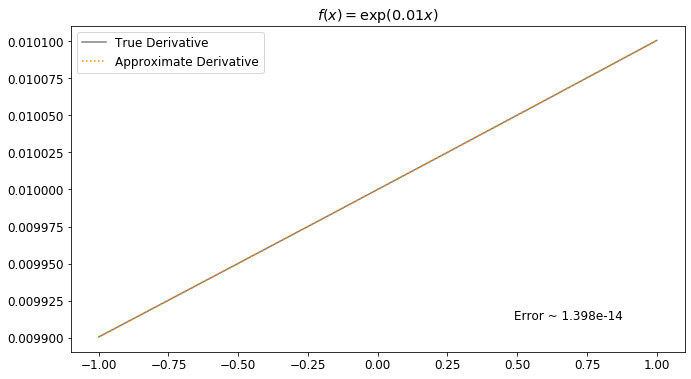

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title(r"$f(x) = $exp$(0.01x)$")
ax.plot(x, true_derivative, color="k", label="True Derivative", alpha=0.5)
ax.plot(x[2:-2], dydx, color="darkorange", label="Approximate Derivative", ls=":")
ax.text(0.9, 0.1, f"Error ~ {error:.3e}", transform=ax.transAxes, horizontalalignment="right")
ax.legend();

In [6]:
x = np.linspace(-1, 1, 100)
y = x ** 3 - 2 * x ** 2
true_derivative = 3 * x ** 2 - 4 * x
dydx = estimate_derivative(x, y)
error = np.std(true_derivative[2:-2] - dydx)

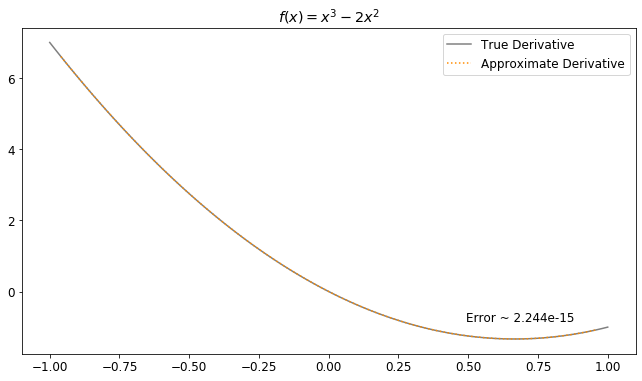

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title(r"$f(x) = x^3 - 2x^2$")
ax.plot(x, true_derivative, color="k", label="True Derivative", alpha=0.5)
ax.plot(x[2:-2], dydx, color="darkorange", label="Approximate Derivative", ls=":")
ax.text(0.9, 0.1, f"Error ~ {error:.3e}", transform=ax.transAxes, horizontalalignment="right")
ax.legend();

Now on to choosing the optimal step size $\delta$. We want to minimize the error in $f'(x)$ with respect to our choice of step size. The error can be written as

## Problem 2

For this problem, we need to write an interpolation function that will convert an input voltage to a temperature, according to measurements provided for the Lakeshore 670 diode. To do this, I will load in the data from the provided $\texttt{lakeshore.txt}$ file and use a cubic spline interpolator from $\texttt{scipy}$ in order to actually perform the interpolation.

In [18]:
data = np.genfromtxt("lakeshore.txt")
# Reverse the order so that the voltages are increasing.
temperatures = data[:,0][::-1]
voltages = data[:,1][::-1]
dVdT = data[:,2][::-1]
assert np.all(voltages[1:] > voltages[:-1])

In [55]:
def estimate_temperature(voltage):
    """
    Estimate the temperature given a voltage for the Lakeshore 670 diode.
    
    Parameters
    ----------
    voltage: array-like of float
        Voltage(s), in Volts, at which to estimate the corresponding temperature,
        in Kelvin.
        
    Returns
    -------
    temperature: ndarray of float
        Temperature(s), in Kelvin, corresponding to the input voltage(s).
    lower_uncertainty: ndarray of float
        Lower uncertainty in the estimated temperature, in Kelvin. (Lower half
        of the error bar.)
    upper_uncertainty: ndarray of float
        Upper uncertainty of the estimated temperature, in Kelvin. (Upper half
        of the error bar.)
    """
    # Use the hard-coded data loaded from lakeshore.txt
    voltage = np.atleast_1d(voltage)
    interpolator = interp1d(voltages, temperatures, kind="cubic", assume_sorted=True)
    temperature = interpolator(voltage)
    
    # Maybe stupid implementation, but the idea here is that we'll use the
    # rate of change of V(T) to estimate the uncertainty. To do that, we'll find
    # the nearest voltages above and below the input voltages, calculate the difference
    # between the measured and input voltages for each of these two sets, then estimate
    # the uncertainty as dT ~ dV / (dV/dT) for each of these sets.
    upper_uncertainties = []
    lower_uncertainties = []
    for volt in voltage:
        upper_voltage = voltages[voltages >= volt][0]
        lower_voltage = voltages[voltages <= volt][-1]
        dV_upper = volt - upper_voltage
        dV_lower = volt - lower_voltage
        upper_uncertainties.append(np.abs(dV_upper * dVdT[voltages >= volt][0]))
        lower_uncertainties.append(np.abs(dV_lower * dVdT[voltages <= volt][-1]))
        
    return temperature, lower_uncertainties, upper_uncertainties

In [57]:
# Test it by looking at the midpoints of the measured voltages.
input_voltages = 0.5 * (voltages[1:] + voltages[:-1])
(
estimated_temperatures,
lower_uncertainties,
upper_uncertainties
) = estimate_temperature(input_voltages)
uncertainties = np.vstack([lower_uncertainties, upper_uncertainties])

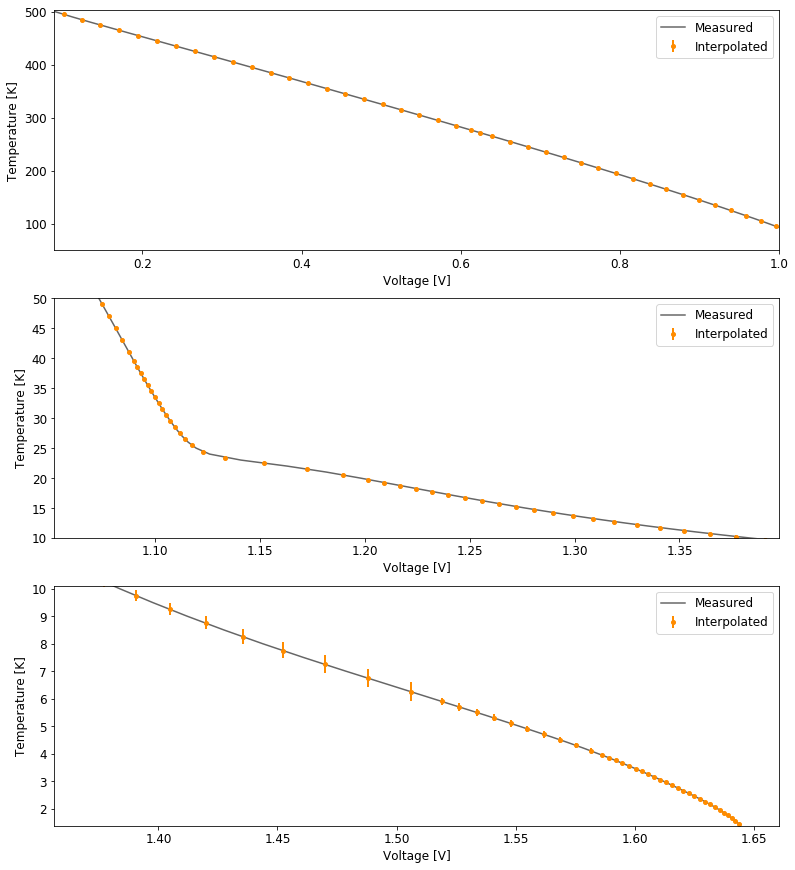

In [58]:
# For choosing plotting windows
T1 = 50
T2 = 10
V1 = voltages[np.argmin(np.abs(temperatures - T1))]
V2 = voltages[np.argmin(np.abs(temperatures - T2))]

# Make a stack of three plots showing different regimes
fig = plt.figure(figsize=(13,15))
axes = fig.subplots(3)
for ax in axes:
    ax.set_xlabel("Voltage [V]")
    ax.set_ylabel("Temperature [K]")
    ax.plot(voltages, temperatures, color="k", alpha=0.6, label="Measured")
    ax.errorbar(
        input_voltages, estimated_temperatures, yerr=uncertainties,
        color="darkorange", lw=0, marker="o", ms=4, label="Interpolated",
        ecolor="darkorange", elinewidth=2
    )
    ax.legend()
    
# Configure the axes appropriately.
axes[0].set_xlim(0.98 * voltages.min(), 1)
axes[0].set_ylim(50, 1.005 * temperatures.max())
axes[1].set_xlim(0.98 * V1, 1.01 * V2)
axes[1].set_ylim(T2, T1)
axes[2].set_xlim(0.98 * V2, 1.01 * voltages.max())
axes[2].set_ylim(0.98 * temperatures.min(), 1.01 * T2);